Notebook based on the [Data Cleaning Tutorial](https://github.com/rkingery/ml_tutorials/blob/master/notebooks/data_cleaning.ipynb) by Ryan Kingery

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
)
from imblearn.over_sampling import RandomOverSampler

In [2]:
data_dir = '/Users/djemec/data/var_effect/'
code_dir = '/Users/djemec/code/variant_effect_predict_ml/'
labeled_data = 'test_1k_tal1_missing.csv'
seed = 123
label = 'impact_ct'

## Reimport Data
Import data from variant_effect_predict_data_munging.ipynb 

In [3]:
df_raw = pd.read_csv(data_dir+labeled_data)

In [4]:
def get_scores(y,yhat):
    print('accuracy: ', round(accuracy_score(y,yhat),4))
    print('precision: ', round(precision_score(y,yhat, average='macro'),4))
    print('recall: ', round(recall_score(y,yhat, average='macro'),4))
    print('f1: ', round(f1_score(y,yhat, average='macro'),4))
    #print('auc: ', round(roc_auc_score(y,yhat),4))
    print('confusion matrix:\n', confusion_matrix(y,yhat))

## Data Cleaning and Feature Engineering: First Pass
We'll use the dataframe generated `df_raw` and drop the `sample` column since it is a duplicate index and save to `df`

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 392 entries, sample to 47225940
dtypes: int64(1), object(391)
memory usage: 3.0+ MB


In [6]:
df = df_raw.copy()
df = df.drop(columns='sample')
df.head()

,impact_ct,47219343,47219348,47219350,47219370,47219382,47219400,47219406,47219415,47219418,...,47225921,47225922,47225924,47225925,47225929,47225933,47225934,47225936,47225939,47225940
0,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
1,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
2,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
3,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
4,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"


let's interogate some of the columns to see the average number of unique values   

In [7]:
# Categories 
df.impact_ct.value_counts()

0    915
1     61
2     24
Name: impact_ct, dtype: int64

In [8]:
sample_cols = [c for c in df.columns if c != 'impact_ct']
count_val_per_feat = [len(df[i].unique()) for i in sample_cols]

In [9]:
for c in set(count_val_per_feat):
    print(str(c) + ' : ' + str(count_val_per_feat.count(c)))

2 : 13
3 : 319
4 : 42
5 : 13
6 : 1
7 : 2


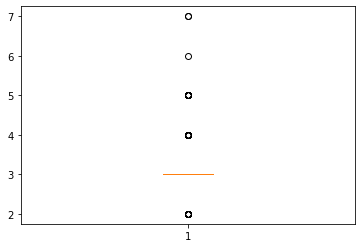

In [10]:
# unique col value count
plt.boxplot(count_val_per_feat)
plt.show()

Since all the values in the dataframe are fairly unique (at most 8 values with an average of 2), we can treat them all as categorical. To do this we'll write a function that gets all the unique values in a column as a dictionary then replaces them with an integer based on  a simple: most frequent = 1, least frequent = n

In [11]:
# create a 
for i in [c for c in df.columns if c != 'impact_ct']:
    df[i] = df[i].astype(str)
    # get the unique values 
    vals = df[i].value_counts(dropna=False).to_dict()
    # overwrite the dictionary counts from 1 to n. this assumes value_counts returns values in most to least common 
    ind = 1
    for l in vals:
        vals[l] = ind
        ind = ind + 1
    # replace the values in the columns with the dictionary created
    df.replace({i: vals}, inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 391 entries, impact_ct to 47225940
dtypes: int64(391)
memory usage: 3.0 MB


,impact_ct,47219343,47219348,47219350,47219370,47219382,47219400,47219406,47219415,47219418,...,47225921,47225922,47225924,47225925,47225929,47225933,47225934,47225936,47225939,47225940
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


now we'll split off `X` (geno positions) and `y` (impact), split off training and test sets, and train a couple models to predict impact)

In [12]:
X = df.drop(columns=['impact_ct']).values
y = df['impact_ct'].values
X.shape, y.shape

((1000, 390), (1000,))

In [13]:
idx_train, idx_test = train_test_split(range(len(y)), test_size =0.3, random_state = seed)

In [14]:
X_train = X[idx_train]
y_train = y[idx_train]
X_test = X[idx_test]
y_test = y[idx_test]

In [15]:
np.unique(y_test)

array([0, 1, 2])

#### random forest

In [16]:
rf_model_baseline = RandomForestClassifier(n_estimators=30, min_samples_leaf=10, n_jobs=-1, random_state=seed)
rf_model_baseline.fit(X_train, y_train)

yhat = rf_model_baseline.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9067
precision:  0.3022
recall:  0.3333
f1:  0.317
confusion matrix:
 [[272   0   0]
 [ 21   0   0]
 [  7   0   0]]


/Users/djemec/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


the random forest in this example is fairly bad. 

#### GBM
now let's train a GBM

In [17]:
gbm_model_baseline = GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbm_model_baseline.fit(X_train, y_train)

yhat = gbm_model_baseline.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9833
precision:  0.963
recall:  0.8571
f1:  0.902
confusion matrix:
 [[272   0   0]
 [  3  18   0]
 [  0   2   5]]


In [18]:
def plot_feature_importances(model, columns):
    top_importances = -np.sort(-model.feature_importances_)
    top_importances = np.sort(top_importances)
    top_importances = [i for i in top_importances if i > .01]
    top_features = np.argsort(-model.feature_importances_)
    top_columns = [columns[i] for i in top_features]
    top_columns = list(reversed(top_columns))
    top_columns = top_columns[-len(top_importances):]
    plt.figure()
    plt.title('Feature Importances')
    plt.barh(range(len(top_columns)), top_importances,
             color='r', align='center')
    plt.yticks(range(len(top_columns)), top_columns)
    plt.ylim([-1, len(top_columns)])
    plt.show()
    return top_columns

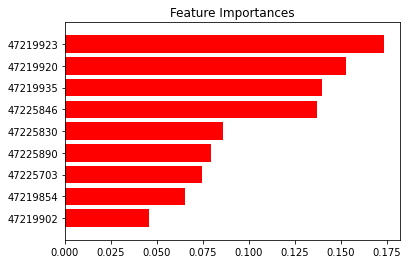

In [19]:
cols = df.drop(columns=['impact_ct']).columns
gbm_top_feat = plot_feature_importances(gbm_model_baseline, cols)

## Setup Results Tracking

In [20]:
#dbSNP true positive sites 
true_positive_sites = ['47219854','47219902','47219920','47219923','47219935','47225703','47225830','47225846','47225890']
result_df = pd.DataFrame({'ground_truth':[True]*len(true_positive_sites) }, index=true_positive_sites)
result_df

,ground_truth
47219854,True
47219902,True
47219920,True
47219923,True
47219935,True
47225703,True
47225830,True
47225846,True
47225890,True


In [21]:
#func to add new columns
def add_result(name,feats):
    global result_df
    if name in result_df.columns:
        print('already added')
        print(result_df)
        return
    in_df = pd.DataFrame({name: True}, index=feats)
    result_df = result_df.join(in_df, how='outer').fillna(False)
    print(result_df)

In [22]:
add_result(name='gbm_baseline', feats=gbm_top_feat)

          ground_truth  gbm_baseline
47219854          True          True
47219902          True          True
47219920          True          True
47219923          True          True
47219935          True          True
47225703          True          True
47225830          True          True
47225846          True          True
47225890          True          True


## One Hot Encoding
One hot encoding is the process in which a categorical feature `{letter:['A','B','C']}` becomes a multiple features, one for each cateogry and a 1/0 value `{letter_A:[1,0,0],letter_B:[0,1,0],letter_C:[0,0,1]}`.  This can improve performance 

In [23]:
df_one_hot = df_raw.drop(columns='sample').copy()
feat_col = [c for c in df_one_hot.columns if c != 'impact_ct']
df_one_hot.head()

,impact_ct,47219343,47219348,47219350,47219370,47219382,47219400,47219406,47219415,47219418,...,47225921,47225922,47225924,47225925,47225929,47225933,47225934,47225936,47225939,47225940
0,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
1,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
2,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
3,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"
4,0,"['A', 'A']","['T', 'T']","['G', 'G']","['A', 'A']","['C', 'C']","['C', 'C']","['C', 'C']","['A', 'A']","['A', 'A']",...,"['C', 'C']","['G', 'G']","['T', 'T']","['C', 'C']","['C', 'C']","['C', 'C']","['G', 'G']","['C', 'C']","['T', 'T']","['G', 'G']"


In [24]:
df_one_hot = pd.get_dummies(df_one_hot, columns=feat_col)
df_one_hot.head()

,impact_ct,"47219343_['A', 'A']","47219343_['A', '_']","47219343_['_', '_']","47219348_['T', 'T']","47219348_['T', '_']","47219348_['_', '_']","47219350_['G', 'G']","47219350_['G', '_']","47219350_['_', '_']",...,"47225936_['C', 'C']","47225936_['C', '_']","47225936_['_', '_']","47225939_['T', 'T']","47225939_['T', '_']","47225939_['_', '_']","47225940_['G', 'A']","47225940_['G', 'G']","47225940_['G', '_']","47225940_['_', '_']"
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
4,0,1,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0


In [25]:
X = df_one_hot.copy().drop(columns=label).values
y = df_one_hot[label].copy().values
X.shape, y.shape

((1000, 1236), (1000,))

In [26]:
X_train = X[idx_train]
y_train = y[idx_train]
X_test = X[idx_test]
y_test = y[idx_test]

#### one hot rf

In [27]:
rf_model_unbal = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
rf_model_unbal.fit(X_train, y_train)

yhat = rf_model_unbal.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.95
precision:  0.958
recall:  0.5714
f1:  0.6436
confusion matrix:
 [[272   0   0]
 [  9  12   0]
 [  5   1   1]]


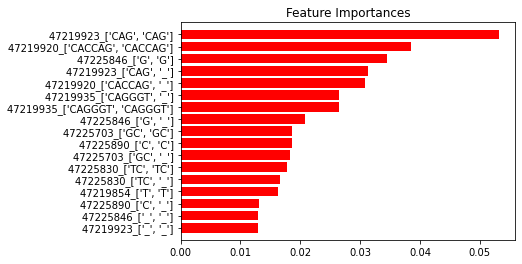

                               ground_truth  gbm_baseline  rf_one_hot
47219854                               True          True       False
47219854_['T', 'T']                   False         False        True
47219902                               True          True       False
47219920                               True          True       False
47219920_['CACCAG', 'CACCAG']         False         False        True
47219920_['CACCAG', '_']              False         False        True
47219923                               True          True       False
47219923_['CAG', 'CAG']               False         False        True
47219923_['CAG', '_']                 False         False        True
47219923_['_', '_']                   False         False        True
47219935                               True          True       False
47219935_['CAGGGT', 'CAGGGT']         False         False        True
47219935_['CAGGGT', '_']              False         False        True
47225703            

In [28]:
cols = df_one_hot.drop(columns=[label]).columns
top_feat = plot_feature_importances(rf_model_unbal, cols)
add_result(name='rf_one_hot', feats=top_feat)

#### one hot gbm

In [29]:
gbm_model_unbal = GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbm_model_unbal.fit(X_train, y_train)

yhat = gbm_model_unbal.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.99
precision:  0.9824
recall:  0.8571
f1:  0.9001
confusion matrix:
 [[272   0   0]
 [  0  21   0]
 [  2   1   4]]


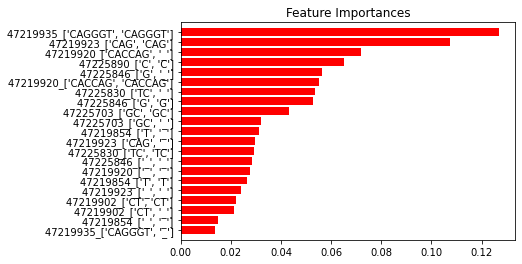

                               ground_truth  gbm_baseline  rf_one_hot  \
47219854                               True          True       False   
47219854_['T', 'T']                   False         False        True   
47219854_['T', '_']                   False         False       False   
47219854_['_', '_']                   False         False       False   
47219902                               True          True       False   
47219902_['CT', 'CT']                 False         False       False   
47219902_['CT', '_']                  False         False       False   
47219920                               True          True       False   
47219920_['CACCAG', 'CACCAG']         False         False        True   
47219920_['CACCAG', '_']              False         False        True   
47219920_['_', '_']                   False         False       False   
47219923                               True          True       False   
47219923_['CAG', 'CAG']               False        

In [30]:
cols = df_one_hot.drop(columns=[label]).columns
top_feat = plot_feature_importances(gbm_model_unbal, cols)
add_result(name='gbm_one_hot', feats=top_feat)

## Oversampling
Since the dataset is fairly skewed, and no current models have worked well enough, we'll perform oversampling using the imblearn `RandomOverSampler` class. This will upsample the training data until the labels are balanced by copying values with minority labels until they're balanced with the majority label.

In [31]:
X_train_bal,y_train_bal = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

In [32]:
print('original training set size: ', len(y_train))
print('new training set size: ', len(y_train_bal))
print('number of negative samples: ', len(y_train_bal[y_train_bal==0]))
print('number of positive samples: ', len(y_train_bal[y_train_bal!=0]))

original training set size:  700
new training set size:  1929
number of negative samples:  643
number of positive samples:  1286


#### oversampled one hot rf

In [33]:
rf_model_bal = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
rf_model_bal.fit(X_train_bal, y_train_bal)

yhat = rf_model_bal.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9567
precision:  0.6317
recall:  0.5714
f1:  0.5964
confusion matrix:
 [[272   0   0]
 [  6  15   0]
 [  6   1   0]]


/Users/djemec/opt/anaconda3/envs/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


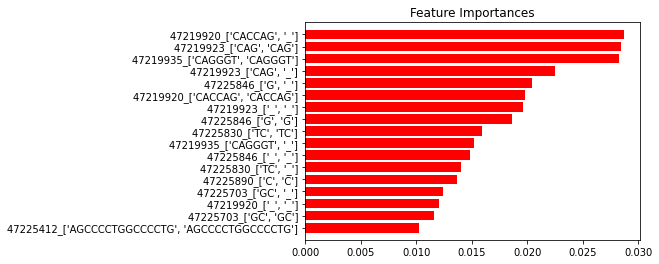

In [34]:
cols = df_one_hot.drop(columns=[label]).columns
top_feat = plot_feature_importances(rf_model_bal, cols)

# add_result(name='rf_one_hot_bal', feats=top_feat)

#### oversampled one hot gbm

In [35]:
gbm_model_bal = GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbm_model_bal.fit(X_train_bal, y_train_bal)

yhat = gbm_model_bal.predict(X_test)
get_scores(y_test, yhat)

accuracy:  0.9933
precision:  0.9836
recall:  0.9048
f1:  0.9361
confusion matrix:
 [[272   0   0]
 [  0  21   0]
 [  1   1   5]]


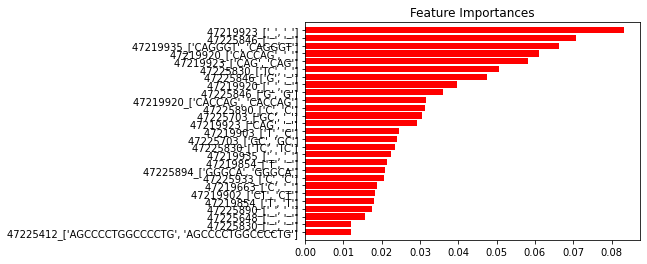

                                                 ground_truth  gbm_baseline  \
47219663_['C', '_']                                     False         False   
47219854                                                 True          True   
47219854_['T', 'T']                                     False         False   
47219854_['T', '_']                                     False         False   
47219854_['_', '_']                                     False         False   
47219902                                                 True          True   
47219902_['CT', 'CT']                                   False         False   
47219902_['CT', '_']                                    False         False   
47219903_['T', 'C']                                     False         False   
47219920                                                 True          True   
47219920_['CACCAG', 'CACCAG']                           False         False   
47219920_['CACCAG', '_']                            

In [36]:
cols = df_one_hot.drop(columns=[label]).columns
top_feat = plot_feature_importances(gbm_model_bal, cols)

add_result(name='gbm_one_hot_bal', feats=top_feat)

## Results

In [37]:
result_df

,ground_truth,gbm_baseline,rf_one_hot,gbm_one_hot,gbm_one_hot_bal
"47219663_['C', '_']",False,False,False,False,True
47219854,True,True,False,False,False
"47219854_['T', 'T']",False,False,True,True,True
"47219854_['T', '_']",False,False,False,True,True
"47219854_['_', '_']",False,False,False,True,False
47219902,True,True,False,False,False
"47219902_['CT', 'CT']",False,False,False,True,True
"47219902_['CT', '_']",False,False,False,True,False
"47219903_['T', 'C']",False,False,False,False,True
47219920,True,True,False,False,False


|(seed=123)|accuracy|precision|recall|F1|Bad?|
|---|---|---|---|---|---|
|rf|~0.9067~|~0.3022~|~0.3333~|~0.317~|Yes|
|gbm|0.9833|0.963|0.8571|0.902||
|rf, onehot|0.95|0.958|0.5714|0.6436||
|gbm, onehot|0.99|0.9824|0.8571|0.9001||
|rf, onehot, bal|~0.9567~|~0.6317~|~0.5714~|~0.5964~|Yes|
|gbm, onehot, bal|**0.9933**|**0.9836**|**0.9048**|**0.9361**||